In [1]:
#load aiida environment and connect to database
from aiida import load_profile

profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [2]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups, WorkChainNode)
from aiida.engine import submit, exceptions
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, kkr_imp_sub_wc
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, KkrCalculation ,VoronoiCalculation
import matplotlib.pyplot as plt

#from aiida_kkr.tools.common_workfunctions import get_username
import matplotlib.gridspec as gridspec
from aiida_kkr.tools import plot_kkr
#from aiida_kkr.tools import find_parent_structure, plot_kkr, kkrparams, neworder_potential_wf


In [3]:
#from aiida_kkr.workflows import kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, kkr_imp_sub_wc
#from aiida_kkr.calculations import KkrimpCalculation, KkrCalculation ,VoronoiCalculation


(-2.0, 2.0)

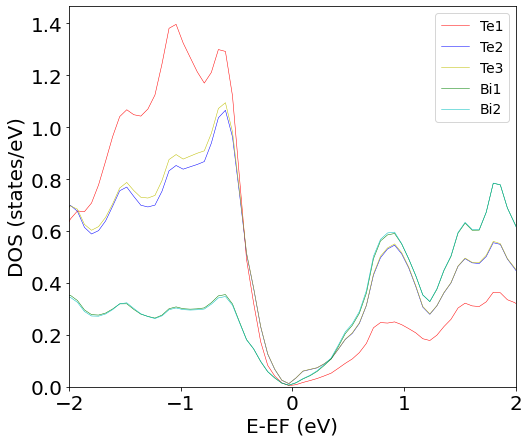

In [171]:
# This is from the Lloyd Dos
dos_ref = load_node('fd831449-2a37-4316-91e0-656829d69f7a')
# Dos from normalised weight
font = {'family':'normal',
        'weight': 'normal',
        'size':20
       }

import matplotlib.pyplot as plt
import matplotlib as m
plt.rc('font',**font)
#cmap= m.cm.get_cmap('RdBu_r', 8)
colors = plt.cm.viridis(np.linspace(0.0, 0.9, 10))
colors = ['r', 'b', 'y', 'g','c']
plt.figure(figsize=(8,7))
dos = load_node('b2c6edee-92f6-4681-8346-c139abc84b13')
for i, label in zip([0,1,2,3,4],['Te1', 'Te2' ,'Te3', 'Bi1', 'Bi2']):
    kwargs = dict(silent=True, sum_spins=True, iatom= [i], color= colors[i], label= label, l_channels=False,
                  nofig=True, noshow=True, lw=0.5)
    plot_kkr(dos_ref, **kwargs)
plt.ylim(0.0)
plt.xlim((-2, 2))

In [5]:
struc_0 = load_node(234)
#struc_0.get_pymatgen_structure()

In [6]:
## This function will help to plot dos_imp
def dos_plot (group_or_wc_list):
    from aiida.orm import load_group, load_node
    if group_or_wc_list == []:
        dos_list= group_or_wc_list
    else:
        try:
            group = load_group(group_or_wc_list)
            dos_list = [i.pk for i in list(group.nodes)[:]]
        except:
            print('{} group is not present is the database.'.format(group_or_wc_list))
   
    for wc in dos_list[:]:
        imp_dos = load_node(wc)
        imp_info = imp_dos.label
        print(imp_info)


        fig2 = plt.figure(figsize=(15.0,4.5))
        spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)

        

        # Total contribution from the entire impurity cluster
        f2_ax1 = fig2.add_subplot(spec2[0, 0])
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True ,label= 'Impurity_Clu1ter',
                     noshow=True, nofig=True, color='C'+str(0), filled=True, alpha=0.3, yscale=1
                )
        # highlight the contibution of the impurity (iatom=0)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label= imp_dos.label,
                     noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0, 
                )
        
            

        f2_ax2 = fig2.add_subplot(spec2[0, 1])
        plot_kkr(imp_dos, l_channels=True, strucplot=False, silent=True, label='Impurity_Cluster',
                noshow=True, nofig=True, color='C'+str(0),filled=True, alpha=0.3, yscale=1, sum_spins= True,)
        plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
                noshow=True, nofig=True, color='C'+str(0), lw=3, iatom=0,all_atoms= False, sum_spins= True,)
        print('impurity_dict', imp_dos.inputs.impurity_info.get_dict())
        
        
        
## execution of the function
#dos_plot(94)

In [7]:
""" 
For the given input 'imp_dos node or ID and intended energy points' it will return .
 Total density of states arround the indent eng points, most prominent orbital (s,p,d,...) 
 dos and corresponding dos value
"""
def dos_spec(imp_dos_or_pk, atom_index = 0, eng=0, dos= False, dos_interpol=False, debug=False):
    if not (dos or dos_interpol):
        return ('Please specify dos or interpol')
    elif dos and dos_interpol:
        return ('Please specify only one, dos or interpol')
    
    import numpy as np
    from aiida.orm import load_node
    from aiida.common.exceptions import NotExistent 
    from aiida_kkr.calculations import KkrCalculation, VoronoiCalculation
    from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_wc
    
    is_id = None
    node_exist = None
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk


## Dos data
    if dos:
        dos_data = dos_node.outputs.dos_data
## Dos data from the dos_interpole
    if dos_interpol:
        dos_data = dos_node.outputs.dos_data_interpol
    dos_data_x = dos_data.get_x()
#     dos_data_x -->> ('E_EF', array([[]]))
    dos_data_y = dos_data.get_y()
    
    if debug:
        print('dos_data_x shape :', np.shape(dos_data_x))
        print('dos_data_y shape :', np.shape(dos_data_y))
    
    # extract the discrete energy list and unit
    discrete_eng, eng_unit = (dos_data_x[1])[0][:], dos_data_x[2]
    if debug:
        print('discrete_eng : ',discrete_eng)
        print('eng_unit : ', eng_unit)
    
    dos_unit = dos_data_y[0][2]
    if debug:
        print('dos_unit : ', dos_unit)
    
    ## In this part only the required dos data will be saved into the dos_data_arr 
    # cut the dos data for total, s, p, ... into that array for tot, s, p, d, more orbital.
   
    # number of dos array e.g., tot, s, p,..orbital
    num = np.shape(dos_data_y)[0]
    if debug:
        print('NUM : ', num)
    
    y_grid = num*2 # to count the spin and down
    x_grid = len(discrete_eng)
    
    if debug:
        print('x_grid, :', x_grid)
        print('y_grid, :', y_grid)

    dos_data_arr = np.zeros((y_grid,x_grid),dtype=float)
    if debug:
        if num == int(y_grid/2):
            print('ok')

    ## The array dos_data_arr consist dos data for the <atom_index> and for all ldos (total, s, p....,ns)
    for i in range(num): 
        l_dos = dos_data_y[i][1]
        dos_data_arr[i*2][:] =  l_dos[atom_index*2][:] # for spin up
        dos_data_arr[i*2+1][:] =  l_dos[atom_index*2 +1][:] # for spin down 
    if debug:    
        print('dos_data_arr shape: ',np.shape(dos_data_arr))
    
    # Find the energy index nearest to eng index
    nearest_eng_point_index = min(range(len(discrete_eng)), key= lambda i : abs(discrete_eng[i] - eng))
    if debug:
        print('min energy : ', nearest_eng_point_index)
    
    ## It returns all the dos along the column at the index <nearest_eng_point_index>
    all_dos = dos_data_arr.T[nearest_eng_point_index][:]
    
    if debug:
        print('shape of the all_dos', np.shape(all_dos))
        print('all_dos data : ',all_dos)
    
    ## total dos_density list at energy point <eng> for an atom <atom index>
    total_dos = [all_dos[0], all_dos[1]]
    ldos_u , ldos_d = [all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==0 ], [all_dos[2+i] for i in range(len(all_dos[2:])) if i%2==1 ]
    # To collecting the lebel from dos_data
    #collect the ldos lebel for max_dos spin up and spin down
    ldos_u_label = dos_data_y[np.argmax(ldos_u[:]) + 1][0] 
    ldos_d_label = dos_data_y[np.argmax(ldos_d[:]) + 1][0]
    
    # Collect the max ldos value 
    max_ldos_up_value = np.max(ldos_u)
    max_ldos_down_value = np.max(ldos_d)
    
    # To collec the data for further invetigation e.g. ploting 
    out_dict = {'dos': {'dos_spin_up': total_dos[0],
                                  'dos_spin_down': total_dos[1]},
                'Most Prominent_ldos': {ldos_u_label + '_spin_up': max_ldos_up_value,
                                      ldos_d_label + '_spin_down': max_ldos_down_value},
                'Units':{'energy_unit': eng_unit,
                         'dos_unit':dos_unit},
                'Other':{'eng':discrete_eng[nearest_eng_point_index],
                         'atom_index':atom_index}
               }
    
    return out_dict
    

In [14]:
## This function will return the desired value from the last calc output_parameters for the given input parameter
## and also some out_parameters from the kkr_imp_scf wc
## DATA has been extructed from dos wc
def conv_dos_data(imp_dos_or_pk, debug= False, dos= False, dos_interpol= False):
    if not (dos or dos_interpol):
        return ('Please specify dos or interpol')
    elif dos and dos_interpol:
        return ('Please specify only one, dos or interpol')
    
    import numpy as np
    from aiida.orm import load_node
    from aiida_kkr.workflows import kkr_imp_sub_wc
    from aiida.common.exceptions import NotExistent 
    from aiida.common.constants import elements as elmt
    summary_data_dict = { 'rms_conv' : 0,
                          'etot_conv_Ry' : 0,
                          'etot_conv_eV' : 0,
                          'imp_spin_moment_mu_Bhor' : 0,
                          'imp_orbital_moment_mu_Bhor' : 0,
                          'imp_total_charge_electron' : 0,
                          'imp_core_charge_electron' : 0,
                          'charge_doping_electron' : 0, # 
                          'DOS_in_gap' : 0,
                     };
    imp_clst_dict = {'atoms_in_impurity_cluster' : 0,
                     'ilayer' : 0,
                     'Zimp' : 0,
                     'Zhost' : 0
                    }
    
    
    try:
        dos_node = load_node(imp_dos_or_pk)
    except NotExistent as e:
        is_id = False
        node_exist = imp_dos_or_pk.is_stored
        if node_exist:
            dos_node = imp_dos_or_pk
    imp_info = dos_node.inputs.impurity_info.get_dict()
    scf_wc = dos_node.inputs.imp_pot_sfd.get_incoming(node_class = kkr_imp_wc).first().node
    scf_out_param = scf_wc.outputs.last_calc_output_parameters.get_dict()
    
    # To extract the host structure from the using the host_Greenfunction_folder comingout from the kkr_flex_wc
    kkr_sub = dos_node.get_outgoing(node_class=kkr_imp_sub_wc).first().node
    kkrimp_calc = kkr_sub.get_outgoing(node_class= KkrimpCalculation).first().node
    host_greenfuntion_folder = kkrimp_calc.inputs.host_Greenfunction_folder
    host_structure, voro_calc = VoronoiCalculation.find_parent_structure(host_greenfuntion_folder)
    
    
    ## Filling the last calc output data
    imp_atom = 0
    dos_eng = 0
    summary_data_dict['rms_conv'] = scf_out_param['convergence_group']['rms']
    summary_data_dict['etot_conv_Ry'] = scf_out_param['total_energy_Ry']
    summary_data_dict['etot_conv_eV'] = scf_out_param['total_energy_Ry'] * 13.6056980659
    summary_data_dict['imp_spin_moment_mu_Bhor'] = scf_out_param['magnetism_group']['spin_moment_per_atom'][imp_atom][-1]
    summary_data_dict['imp_orbital_moment_mu_Bhor'] = scf_out_param['magnetism_group']['orbital_moment_per_atom'][imp_atom][:]
    summary_data_dict['imp_total_charge_electron'] = scf_out_param['total_charge_per_atom'][imp_atom]
    summary_data_dict['imp_core_charge_electron'] = scf_out_param['charge_core_states_per_atom'][imp_atom]
    charge_doping = imp_info['Zimp'] - summary_data_dict['imp_total_charge_electron']
    summary_data_dict['charge_doping_electron'] = charge_doping
    
    spec_dos_data = dos_spec(imp_dos_or_pk=dos_node, dos=dos, 
                             dos_interpol=dos_interpol, 
                             atom_index=imp_atom, eng=dos_eng,
                             debug=debug)
    dos_in_gap = spec_dos_data['dos']['dos_spin_up'] + spec_dos_data['dos']['dos_spin_down']
    summary_data_dict['DOS_in_gap'] = dos_in_gap

    
    # Filling the imp_cluster data
    cluster_size = len(scf_out_param['total_charge_per_atom'])
    zimp = imp_info['Zimp']
    zhost = 0 # TODO: Have to find it later
    ilayer = imp_info['ilayer_center']
    # To find the Zimp from the host structure
    sym_to_Znum = {val['symbol']:num for num,val in elmt.items() }
    ilayer_host_symbol = host_structure.sites[ilayer].kind_name
    zhost = sym_to_Znum[ilayer_host_symbol]
    
    
    
    
    
    imp_clst_dict['atoms_in_impurity_cluster'] = cluster_size
    imp_clst_dict['ilayer'] = ilayer
    imp_clst_dict['Zimp'] = zimp
    imp_clst_dict['Zhost'] = zhost
    return summary_data_dict, imp_clst_dict

In [15]:
# To plot some data

from aiida.common.constants import elements as elmt

group_ilayer_4 = load_group(107)
node_list = list(group_ilayer_4.nodes)


def gap_dos_spin_orbital_mom_plot_data(group_pk=None, debug= False):
    
    """
        inputs:
            group_pk : group kkr_imp_wc node to collect data for ploting
        retruns:
            truple(imp_list, gap_dos_list, spin_moment_list, orbital_moment_list): 
                        imp_list-> list of impurity symbol
                        gap_dos_list -> list density of states in gap
                        spin_mement_list -> spin momentum list of the impurities
                        orbiral_moment_list -> orbital momentum list of the impurities
    """
    
    if group_pk:
        group_ilayer_4 = load_group(group_pk)
    else:
        group_ilayer_4 = load_group(107)
        
    node_list = list(group_ilayer_4.nodes)
    # All intended data list for ploting.
    imp_list = []
    gap_dos_list = []
    spin_moment_list = []
    orbital_moment_list = []

    #Hre collect the data for each imp_dos_calc
    for i in range(len(node_list)):
        dos_dict, clst_dict = conv_dos_data(imp_dos_or_pk=node_list[i],dos= False, dos_interpol=True, debug=False)
        imp_list.append(clst_dict['Zimp'])
        gap_dos_list.append(dos_dict['DOS_in_gap'])

        # Collect the spin moment
        spin_moment = dos_dict['imp_spin_moment_mu_Bhor']# pow(sum([i**2 for i in dos_dict['imp_spin_moment_mu_Bhor']]), 0.5) 
        spin_moment_list.append(spin_moment)

        # Collect the orbital moment
        orbital_moment = pow(sum([i**2 for i in dos_dict['imp_orbital_moment_mu_Bhor']]), 0.5)
        orbital_moment_list.append(orbital_moment)
    
    
    if debug:
        print('test gap_do_list :', gap_dos_list)
        print('test spin_moment_list :', spin_moment_list)
        print('test orbital_moment_list :', orbital_moment_list)
    
    return (imp_list, gap_dos_list, spin_moment_list, orbital_moment_list)



['Y', 'Zr', 'Mo', 'Nb', 'Cu', 'Tc', 'Ti', 'V', 'Ru', 'Cr', 'Mn', 'Rh', 'Fe', 'Ag', 'Co', 'Cd', 'Ni', 'Pd', 'Zn']


/tmp/ipykernel_4036292/2605185617.py:61: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(imp_list_107, xlabel, Fontsize= 20)


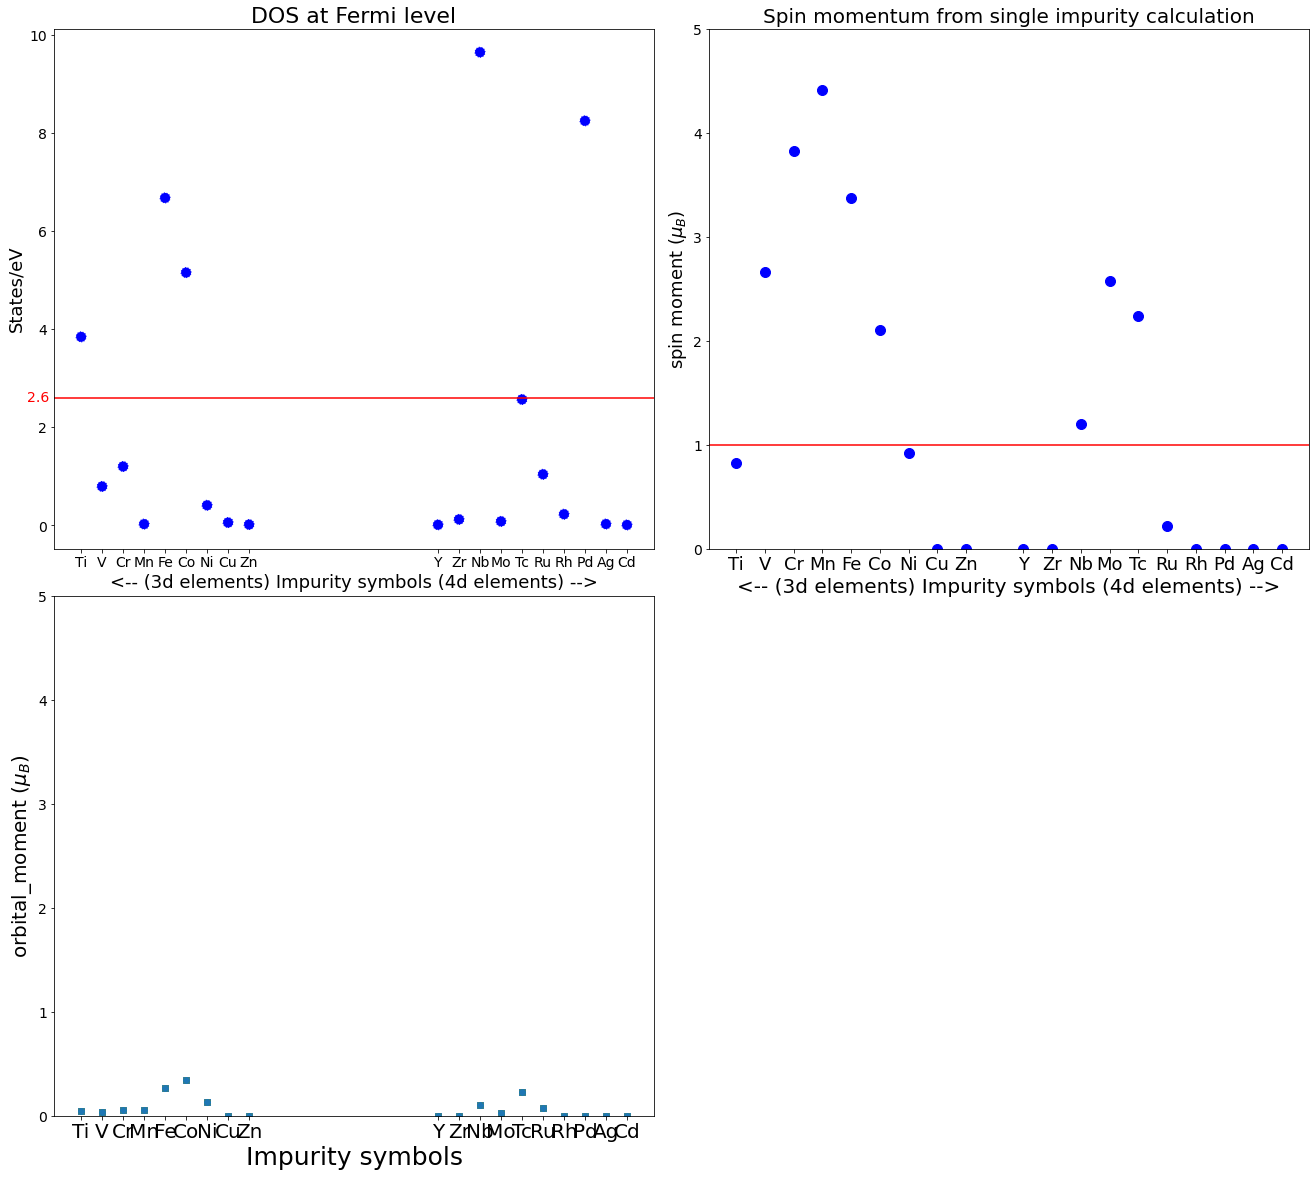

'4.557'

In [161]:

#(imp_list_107, gap_dos_list_107, spin_moment_list_107, orbital_moment_list_107) = gap_dos_spin_orbital_mom_plot_data(107)
#(imp_list_108, gap_dos_list_108, spin_moment_list_108, orbital_moment_list_108) = gap_dos_spin_orbital_mom_plot_data(107)

## Plot some out_put_data Vs imp



plt.subplot2grid((4,4), (0,2), colspan=2, rowspan=2)
#plt.scatter(imp_list_107, np.array(spin_moment_list_107), marker='s',)

imp_arr = np.array(imp_list_108)
for i in range(len(imp_list_108)):
    if imp_list_108[i]>30:
        imp_arr[i] -= 7
plt.scatter(imp_arr, spin_moment_list_108, marker='o', s=100, color='b')
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Spin momentum from single impurity calculation', fontsize= 20)
plt.xlabel('<-- (3d elements) Impurity symbols (4d elements) -->',  fontsize= 20)
plt.ylabel('spin moment ($\mu_B$)', fontsize= 18)
plt.ylim((0.0,5.0))
plt.axhline(1, color='r', label='2.5')
#plt.text(21,1, '1.0', color='r', ha='right', va='center')
xlabel = [elmt[i]['symbol'] for i in imp_list_108[:]]
print(xlabel)
plt.xticks(imp_arr, xlabel, fontsize=18)

ax=plt.subplot2grid((4,4), (2,0), colspan=2, rowspan=2)
ax.scatter(imp_list_107, orbital_moment_list_107, marker='s')
ax.scatter(imp_list_108, np.array(orbital_moment_list_108), marker='o')

ax.plot(imp_list_108, orbital_moment_list_108, 'o')
plt.scatter(imp_list_107, orbital_moment_list_107, )
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
#plt.title('imp_spin_moment Vs imp')
plt.xlabel('Impurity symbols',  fontsize=25)
plt.ylabel('orbital_moment ($\mu_B$)',  fontsize=20)
plt.ylim((0.0,5.0))
xlabel = [elmt[i]['symbol'] for i in imp_list_107[:]]
plt.xticks(imp_list_107, xlabel, Fontsize= 20)

plt.show()
'%.3f'%(4.5574844)

([<matplotlib.axis.XTick at 0x7f2afc3f6fa0>,
 [Text(39, 0, 'Y'),
  Text(40, 0, 'Zr'),
  Text(42, 0, 'Mo'),
  Text(41, 0, 'Nb'),
  Text(29, 0, 'Cu'),
  Text(43, 0, 'Tc'),
  Text(22, 0, 'Ti'),
  Text(23, 0, 'V'),
  Text(44, 0, 'Ru'),
  Text(24, 0, 'Cr'),
  Text(25, 0, 'Mn'),
  Text(45, 0, 'Rh'),
  Text(26, 0, 'Fe'),
  Text(47, 0, 'Ag'),
  Text(27, 0, 'Co'),
  Text(48, 0, 'Cd'),
  Text(28, 0, 'Ni'),
  Text(46, 0, 'Pd'),
  Text(30, 0, 'Zn')])

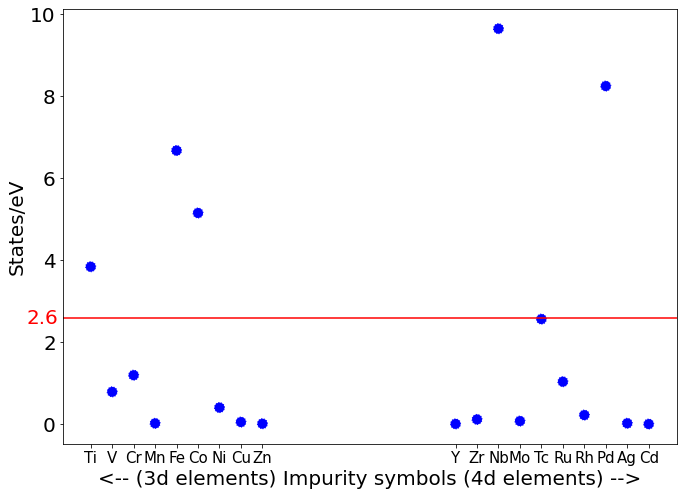

In [184]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
plt.figure(1, figsize=(11,8))
gdspec.GridSpec(1,1)

# Plot DOS in gap Vs imp
plt.subplot2grid((1,1), (0,0), colspan=2, rowspan=2)

plt.scatter(imp_list_107, gap_dos_list_107, marker= 'o', s= 100, color='b', ls=':'  )
#plt.scatter(imp_list_108, gap_dos_list_108, marker= 's', s= 100, color='b', ls=':')
#plt.plot(np.arange(len(imp_list_108)), gap_dos_list_108, marker= 's',color='b', ls=':')
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=10)
#plt.title('DOS at Fermi level',  fontsize=20)
plt.xlabel('<-- (3d elements) Impurity symbols (4d elements) -->',  fontsize=20)
plt.ylabel('States/eV',  fontsize=20)
plt.axhline(2.6, color='r', label='2.6')
xlabel = [elmt[i]['symbol'] for i in imp_list_107[:]]
plt.text(20.5,2.6, '2.6', color='r', ha='right', va='center')
plt.xticks(imp_list_107, xlabel, fontsize= 15)
#plt.legend()

In [139]:
imp_list_108.sort()
imp_arr = np.array(imp_list_108)
imp_arr[9:] = imp_arr[9:]-5 
imp_arr
len(imp_arr), len(spin_moment_list_108)

(19, 19)

In [38]:
[elmt[i]['symbol'] for i in imp_list_107[:]]

['Y',
 'Zr',
 'Mo',
 'Nb',
 'Cu',
 'Tc',
 'Ti',
 'V',
 'Ru',
 'Cr',
 'Mn',
 'Rh',
 'Fe',
 'Ag',
 'Co',
 'Cd',
 'Ni',
 'Pd',
 'Zn']

In [32]:
grp_108 = load_group(108)
for nod in grp_108.nodes:
    if 'Co' in nod.label:
        print(node.label)

In [45]:
for zimp, dos in zip(imp_list_107, gap_dos_list_107):
    print(zimp, dos)

39 0.050177778568164993
40 0.31617937688240216
42 0.3691954926179437
41 5.963745746680727
29 0.32695700762863633
43 2.852125755091331
22 3.873499321654637
23 1.9296629001352381
44 2.2905049725670774
24 1.4344387055077343
25 0.17543066860398493
45 0.9112704683639816
26 5.728075547103088
47 0.14346883634514
27 5.174032634567826
48 0.042490230496723944
28 1.2481216094341376
46 4.465954555167508
30 0.0648045484641034


In [46]:
## Plot 2D data from combine impurity
group_102 = load_group(102)
def TwoDData_extract(group):
    combine_imps_group = load_group(102)
    combine_nodes_list = list(combine_imps_group.nodes)
    time_per_iter = list()
    for node in combine_nodes_list[:]:
        
        last_calc_param = node.outputs.last_calc_output_parameters.get_dict()
        ## To extract the iteration time per iter
        total_running_time = last_calc_param['timings_group']['Total running time']
        total_iter = last_calc_param['convergence_group']['number_of_iterations']
        per_iter = total_running_time/total_iter
        
        time_per_iter.append(per_iter)
    
    return time_per_iter
        
        ##
time_per_iter = TwoDData_extract(group_102)



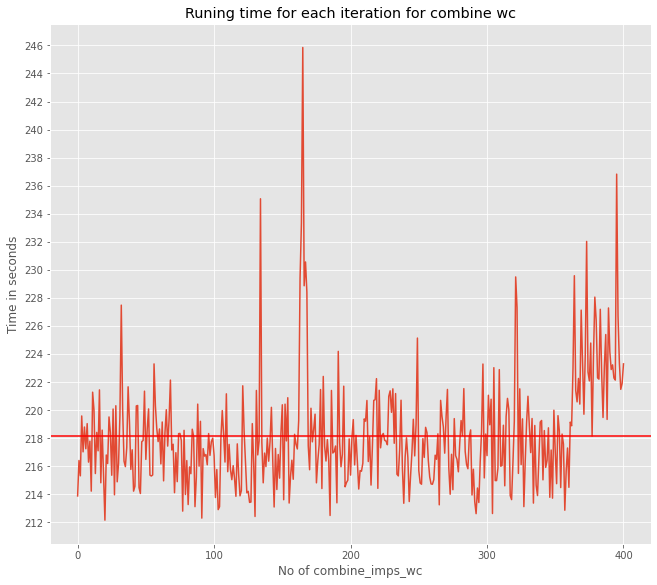

In [47]:
## Plot some out_put_data Vs imp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdspec
fig = plt.figure(1, figsize=(15*1.5,20))
gdspec.GridSpec(4,4)

# Plot DOS in gap Vs imp

plt.subplot2grid((4,4), (0,0), colspan=2, rowspan=2)
plt.plot(time_per_iter)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=20)
plt.title('Runing time for each iteration for combine wc')
plt.xlabel('No of combine_imps_wc')
plt.ylabel('Time in seconds')
plt.axhline(np.average(time_per_iter), c='RED')
# xlabel = [elmt[i]['symbol'] for i in imp_list[:]]
# plt.xticks(imp_list, xlabel)

plt.savefig('runtime for iteration.pdf', dpi=100.0, pad_inches=.05)
plt.show()


In [35]:
# diamar_plot(104,)

In [48]:
## Some other plots for combined_imps data
## Spin momentum along the z axis taking count only one imp of the two
## TODO: Also add the another data for second same impurity and average them, The calcualation AB and BA
group = 102
import matplotlib as mpl

mpl.style.use('ggplot')
spin_data_array, spin_xtick_labels, spin_ytick_labels = ExtractLastCalcData(group, Average= False, key1 = 'magnetism_group', key2='spin_moment_per_atom' , key3=0, key4=2)
## here the parameter 'average' should set to be false as here nothing to be average as this anly use for np.array 

# spin_data_array
arr_shape= np.shape(spin_data_array)
max_val= np.max(spin_data_array)
min_val= np.min(spin_data_array)
xtick_loc= range(len(spin_xtick_labels[1:]))
xtick_lab = spin_xtick_labels[1:]


n = arr_shape[0]
color = plt.cm.hot_r(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
line_design= ['o--', 'o-', '+--', '--', '*--']
    
fig, ax_zs_mom= plt.subplots(1,1, figsize=(15,10))
for i in range(arr_shape[0]):
    
    line= list(spin_data_array[i,1:])
    ax_zs_mom.plot(line, line_design[i%len(line_design)], label=f'{spin_ytick_labels[i]}', color= color[n-1-i])
leg= ax_zs_mom.legend(loc= 'upper right', shadow= True, bbox_to_anchor=[1.3,1],  ncol= 2, title="impurities", fancybox= True )
leg.get_title().set_color('blue')
leg.get_title().set_fontsize(15)
plt.xticks(xtick_loc, xtick_lab)
plt.show()


NameError: name 'ExtractLastCalcData' is not defined

In [50]:
#plot_kkr 3d elements
plot_group= load_group(94)
plt.figure(figsize=(10,10))
list_3d_atom= ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn' ]
ls = ['--', '-', ':']
colors = ['Blues', 'R3', 'C9', 'C12', 'C15', 'C18', 'C21', 'C24', 'C27', 'C30']
i= 0
for node in plot_group.nodes[:]:
    imp = node.label.split(':')[0]
    if imp in ['V']:#list_3d_atom:
        
        plot_kkr(node, strucplot= False, iatom=0, ls= ls[i%3],  
                 label= imp, color= colors[i], silent= True, 
                 sum_spins= True, l_channels= False, nofig=True, 
                 noshow= True, lw= 4,)# title= None)
        i += 1
        
plt.xlim(-2,4)
plt.legend(fontsize= 'x-large')
plt.show()

ValueError: structure not found

<Figure size 720x720 with 0 Axes>

node label :  Mo:Bi2Te3dos_(-1,1)
node pk :  59284
node label :  Nb:Bi2Te3dos_(-1,1)
node pk :  59293
node label :  V:Bi2Te3dos_(-1,1)
node pk :  59198
node label :  Ru:Bi2Te3dos_(-1,1)
node pk :  59327
node label :  Cr:Bi2Te3dos_(-1,1)
node pk :  59204
node label :  Mn:Bi2Te3dos_(-1,1)
node pk :  59212
node label :  Rh:Bi2Te3dos_(-1,1)
node pk :  59340
node label :  Fe:Bi2Te3dos_(-1,1)
node pk :  59221
node label :  Co:Bi2Te3dos_(-1,1)
node pk :  59232
node label :  Pd:Bi2Te3dos_(-1,1)
node pk :  59375


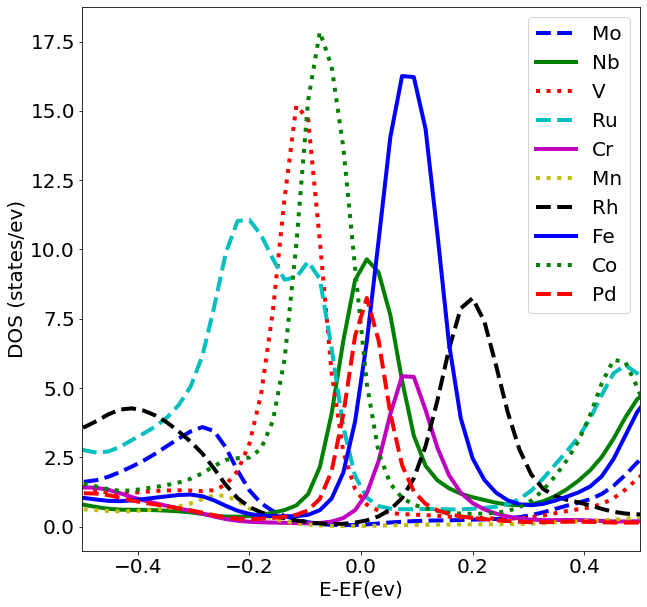

In [180]:
#plot_kkr

font = {'family':'normal',
        'weight': 'normal',
        'size':20
       }
plot_group1= load_group(107)
plot_group2= load_group(108)

plt.figure(figsize=(10,10))
#plt.figure(figsize=(10,10))

list_4d_atom= ['Pd', 'Nb', 'Mo', 'Ru', 'Rh']
list_3d_atom= ['Fe', 'Co', 'V', 'Cr','Mn']
#list_4d_atom= ['Tc','Ru']#['Y','Zr','Mo','Nb','Tc','Ru','Rh','Ag','Cd','Pd']
#list_3d_atom= ['Sc', 'V', 'Cr', 'Mn', 'Ti', 'Co', 'Cu', 'Zn',  'Ni',   'Fe']

ls = ['--', '-', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

i= 0
for node_ in list(plot_group1.nodes)[:]:
    imp = node_.label.split(':')[0]
    if imp in list_3d_atom + list_4d_atom:
        print('node label : ', node_.label)
        print('node pk : ', node_.pk)
        
        dos_data = node_.outputs.dos_data
        plot_kkr(node_, strucplot= False, iatom=0, ls= ls[i%3],  
                 label= imp, color= colors[i%7], silent= True, 
                 sum_spins= True, l_channels= False, nofig=True, 
                 noshow= True, lw= 4)# title= None)
        i += 1
plt.rc('font', **font)
#plt.axvline(0.0105)
#plt.axhline(1.5)
plt.xlim(-0.5,0.5)
plt.xlabel('E-EF(ev)',fontsize=20)
plt.ylabel('DOS (states/ev)',fontsize=20)
plt.title(label= None)
plt.legend(fontsize= 20, loc=1, ncol=1)
plt.show()

In [50]:
group_107 = load_group(107)
for nod in group_107.nodes:
    print(nod.label)

Y:Bi2Te3dos_(-1,1)
Zr:Bi2Te3dos_(-1,1)
Mo:Bi2Te3dos_(-1,1)
Nb:Bi2Te3dos_(-1,1)
Cu:Bi2Te3dos_(-1,1)
Tc:Bi2Te3dos_(-1,1)
Ti:Bi2Te3dos_(-1,1)
V:Bi2Te3dos_(-1,1)
Ru:Bi2Te3dos_(-1,1)
Cr:Bi2Te3dos_(-1,1)
Mn:Bi2Te3dos_(-1,1)
Rh:Bi2Te3dos_(-1,1)
Fe:Bi2Te3dos_(-1,1)
Ag:Bi2Te3dos_(-1,1)
Co:Bi2Te3dos_(-1,1)
Cd:Bi2Te3dos_(-1,1)
Ni:Bi2Te3dos_(-1,1)
Pd:Bi2Te3dos_(-1,1)
Zn:Bi2Te3dos_(-1,1)


In [109]:
plot_group= load_group(107)
xx=plot_group.nodes[0]#.node
xx.outputs.dos_data_interpol

<XyData: uuid: 5f3da16c-8ebc-4b00-8b72-20be230b6e3f (pk: 59942)>

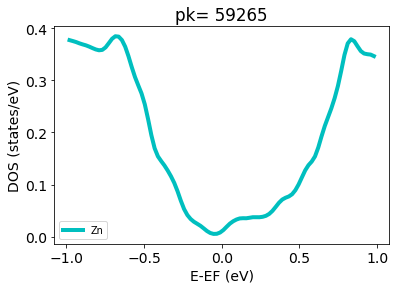

In [111]:
plot_kkr(xx,strucplot= False, iatom=0, ls= ls[i%3],  
                 label= imp, color= colors[i%7], silent= True, 
                 sum_spins= True, l_channels= False, nofig=True, 
                 noshow= True, lw= 4)